In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold, ParameterGrid

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            nn.SELU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU(),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.SELU())
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.SELU(),
                                        nn.Linear(32, 8),
                                        nn.SELU(),
                                        nn.Linear(8, 1))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.regressor(x)
        return x

In [5]:
data_name = "all_221_cp5_3_species_oxides"
fig_folder = "plots_SELU/"

In [6]:
df = pd.read_pickle(f"data/{data_name}.pkl")
df = drop_duplicates(df)
df

Number of molecules 1983


,auid,aurl,compound,composition,species,natoms,spacegroup,pearson_symbol,geometry,positions_fractional,positions_cartesian,enthalpy_atom,enthalpy_formation_atom
0,aflow:b778fabdb1b01db1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAlO/T00...,Ag1Al1O3,"[1, 1, 3]","[Ag, Al, O]",5,221,cP5,"[3.7688035, 3.7688035, 3.7688035, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.8844, 1.8844, 1.8844], [0...",-5.04863,-0.775736
2,aflow:272cd0e74db84a51,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAsO/T00...,Ag1As1O3,"[1, 1, 3]","[Ag, As, O]",5,221,cP5,"[3.7951634, 3.7951634, 3.7951634, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.89758, 1.89758, 1.89758],...",-4.55519,-0.100528
4,aflow:7e6bdbc495310b44,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAuO/T00...,Ag1Au1O3,"[1, 1, 3]","[Ag, Au, O]",5,221,cP5,"[4.1003175, 4.1003175, 4.1003175, 90.0, 90.0, ...","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [2.05016, 2.05016, 2.05016],...",-2.80408,1.37453
6,aflow:c0e1c25976bb4c75,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgB_hO/T0...,Ag1B1O3,"[1, 1, 3]","[Ag, B, O]",5,221,cP5,"[3.484261, 3.484261, 3.484261, 90.0, 90.0, 90.0]","[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...","[[0.0, 0.0, 0.0], [1.74213, 1.74213, 1.74213],...",-4.55549,0.30734
8,aflow:3b79b8b28a5d5cc1,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgBa_svO/...,Ag1Ba1O3,"[1, 1, 3]","[Ag, Ba, O]",5,221,cP5,"[4.7271734, 4.7271734, 4.7271734, 90.0, 90.0, ...","[[-0.0, 0.0, -0.0], [0.5, 0.5, 0.5], [-0.0, 0....","[[-0.0, 0.0, -0.0], [2.36359, 2.36359, 2.36359...",-3.52096,0.388015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3947,aflow:e243d024b0749ac0,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZn/T00...,O3Xe1Zn1,"[3, 1, 1]","[O, Xe, Zn]",5,221,cP5,"[4.370543, 4.370543, 4.370543, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.18527, 2.18527], [2.18527, 0.0, 2.185...",-1.89960,None
3949,aflow:ae4a07b2d68c2933,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZr_sv/...,O3Xe1Zr1,"[3, 1, 1]","[O, Xe, Zr]",5,221,cP5,"[4.322477, 4.322477, 4.322477, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[-0.0, 2.16124, 2.16124], [2.16124, -0.0, 2.1...",-5.89112,-1.222
3951,aflow:0d9d3ce033a32aae,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZn/T...,O3Y1Zn1,"[3, 1, 1]","[O, Y, Zn]",5,221,cP5,"[4.3517566, 4.3517566, 4.3517566, 90.0, 90.0, ...","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.17588, 2.17588], [2.17588, 0.0, 2.175...",-5.57716,-1.07268
3953,aflow:627232532ed2fb40,aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZr_s...,O3Y1Zr1,"[3, 1, 1]","[O, Y, Zr]",5,221,cP5,"[4.155165, 4.155165, 4.155165, 90.0, 90.0, 90.0]","[[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...","[[0.0, 2.07758, 2.07758], [2.07758, 0.0, 2.077...",-8.70129,-2.74124


In [7]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(79,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K',
        'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni',
        'O', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Re',
        'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tb',
        'Tc', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Yb', 'Zn',
        'Zr'], dtype='<U2'))

In [8]:
net = VoxelNet(nchannel)
count_parameters(net)

81073

##  Cartesian

(1784, 13) (199, 13)
Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.042786598205566 val loss 3.4420368671417236
Epoch 1: train loss 2.2276499271392822 val loss 2.301090717315674
Epoch 2: train loss 2.0687930583953857 val loss 2.1955337524414062
Epoch 3: train loss 1.8766776323318481 val loss 1.9986697435379028
Epoch 4: train loss 1.3838999271392822 val loss 1.1128392219543457
Epoch 5: train loss 0.6126717925071716 val loss 0.6515576243400574
Epoch 6: train loss 0.3997688591480255 val loss 0.6038097739219666
Epoch 7: train loss 0.42647045850753784 val loss 0.5344315767288208
Epoch 8: train loss 0.39392220973968506 val loss 0.4994639456272125
Epoch 9: train loss 0.33262431621551514 val loss 0.48317447304725647
Epoch 10: train loss 0.334

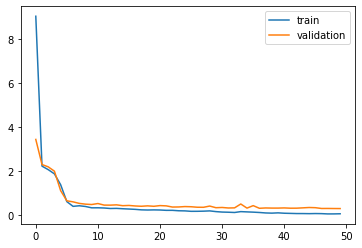

In [9]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.00)

### Train Plots

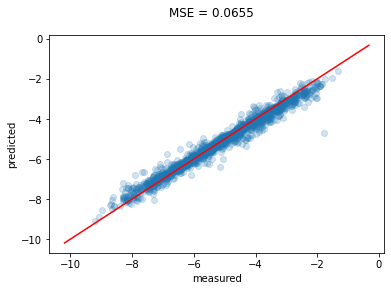

In [10]:
# 0.0655 50 epoch
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

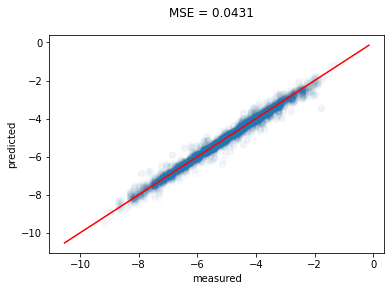

In [11]:
# 0.0431 50 epoch
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_train.pdf")

### Test Plots

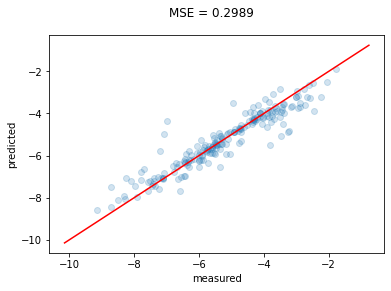

In [12]:
# 0.2989 50 epoch
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

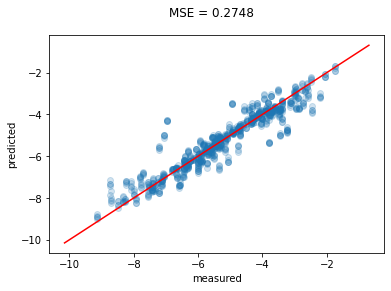

In [13]:
# 0.2748 50 epoch
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_cartesian_test.pdf")

## Spherical

(1784, 13) (199, 13)
Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.046587944030762 val loss 3.4036097526550293
Epoch 1: train loss 2.169504404067993 val loss 2.183715343475342
Epoch 2: train loss 1.8985360860824585 val loss 1.8495608568191528
Epoch 3: train loss 1.2516200542449951 val loss 0.7765289545059204
Epoch 4: train loss 0.45786356925964355 val loss 0.49583837389945984
Epoch 5: train loss 0.3763634264469147 val loss 0.5120257139205933
Epoch 6: train loss 0.36201122403144836 val loss 0.4489908218383789
Epoch 7: train loss 0.37416720390319824 val loss 0.4667428135871887
Epoch 8: train loss 0.38513967394828796 val loss 0.5348819494247437
Epoch 9: train loss 0.33678337931632996 val loss 0.4286249577999115
Epoch 10: train loss 0.32

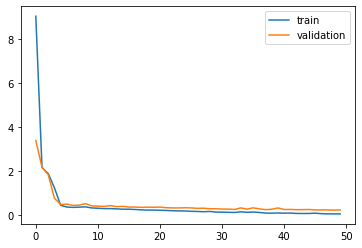

In [14]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='spherical')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='spherical')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.00)

### Train Plots

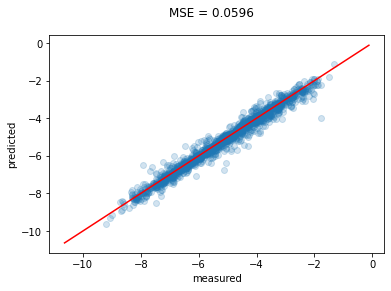

In [15]:
# 0.0596 50 epoch
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

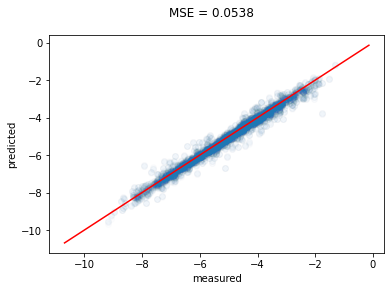

In [16]:
# 0.0538 50 epoch
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_train.pdf")

### Test Plots

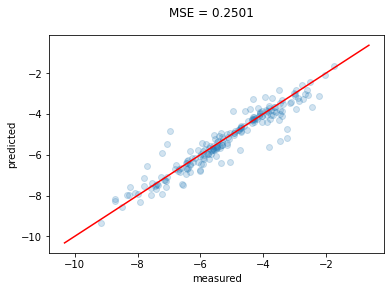

In [18]:
# 0.2501 50 epoch
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)
plt.show()

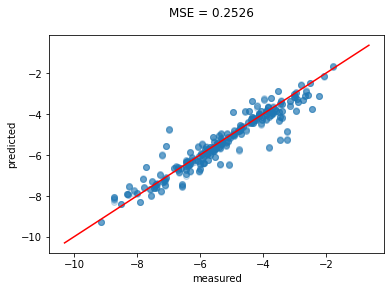

In [19]:
# 0.2526 50 epoch
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)
plt.savefig(fig_folder + data_name + "_spherical_test.pdf")

## Cross Validation

### Cartesian

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.48731803894043 val loss 3.0923118591308594
Epoch 1: train loss 2.4315712451934814 val loss 2.211552381515503
Epoch 2: train loss 2.109635353088379 val loss 2.0170912742614746
Epoch 3: train loss 1.9790080785751343 val loss 1.8728885650634766
Epoch 4: train loss 1.720902442932129 val loss 1.4958624839782715
Epoch 5: train loss 0.9455206394195557 val loss 0.9359564185142517
Epoch 6: train loss 0.5464471578598022 val loss 0.5160031914710999
Epoch 7: train loss 0.3842014968395233 val loss 0.5205064415931702
Epoch 8: train loss 0.3720816969871521 val loss 0.45826593041419983
Epoch 9: train loss 0.3614344894886017 val loss 0.42713141441345215
Epoch 10: train loss 0.3408049941062927 val loss 0.4

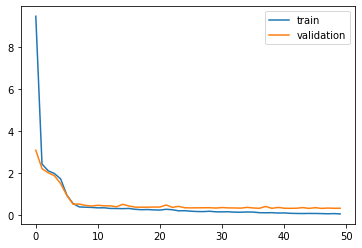

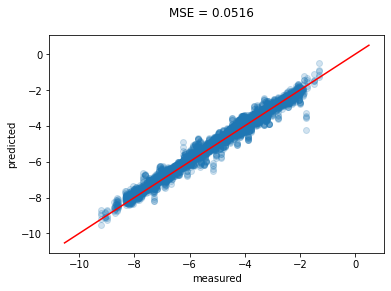

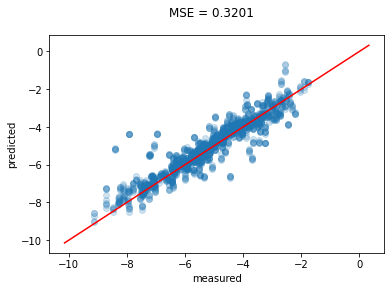

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 8.307862281799316 val loss 2.514836311340332
Epoch 1: train loss 2.261296272277832 val loss 2.2277779579162598
Epoch 2: train loss 2.032123565673828 val loss 2.1390128135681152
Epoch 3: train loss 1.8915280103683472 val loss 1.9482448101043701
Epoch 4: train loss 1.568079948425293 val loss 1.4095680713653564
Epoch 5: train loss 0.7797683477401733 val loss 0.8502988815307617
Epoch 6: train loss 0.49362972378730774 val loss 0.42437466979026794
Epoch 7: train loss 0.41130638122558594 val loss 0.4445536732673645
Epoch 8: train loss 0.371142715215683 val loss 0.45414504408836365
Epoch 9: train loss 0.4064735174179077 val loss 0.41085946559906006
Epoch 10: train loss 0.35044801235198975 val loss 

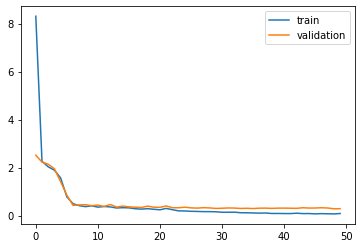

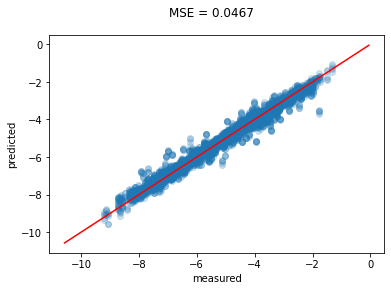

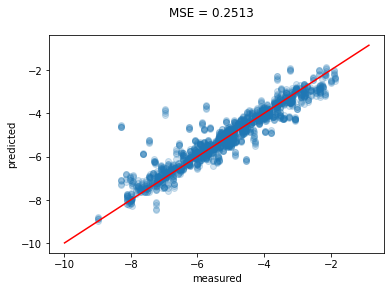

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 7.629096984863281 val loss 2.180324077606201
Epoch 1: train loss 2.2733309268951416 val loss 2.4368896484375
Epoch 2: train loss 2.1090471744537354 val loss 2.0157437324523926
Epoch 3: train loss 1.9743030071258545 val loss 1.9890974760055542
Epoch 4: train loss 1.7105485200881958 val loss 1.5348632335662842
Epoch 5: train loss 0.8325601816177368 val loss 0.6829366683959961
Epoch 6: train loss 0.5762872695922852 val loss 0.5188060998916626
Epoch 7: train loss 0.4676286578178406 val loss 0.5264506936073303
Epoch 8: train loss 0.381158709526062 val loss 0.7525327801704407
Epoch 9: train loss 0.37333187460899353 val loss 0.48785823583602905
Epoch 10: train loss 0.3452293276786804 val loss 0.50

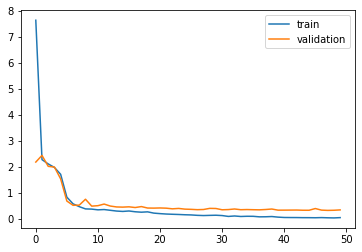

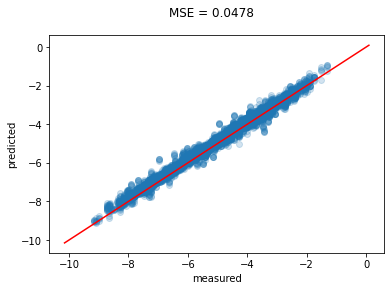

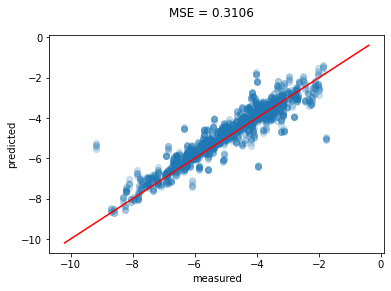

Initialised MolLoader with 1587 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 10.703718185424805 val loss 3.2553272247314453
Epoch 1: train loss 2.4256014823913574 val loss 2.131910562515259
Epoch 2: train loss 2.1120221614837646 val loss 2.073176860809326
Epoch 3: train loss 1.901010274887085 val loss 1.8862634897232056
Epoch 4: train loss 1.5311949253082275 val loss 1.3431769609451294
Epoch 5: train loss 0.6688950061798096 val loss 0.50364089012146
Epoch 6: train loss 0.39478540420532227 val loss 0.43737661838531494
Epoch 7: train loss 0.35783544182777405 val loss 0.4204338788986206
Epoch 8: train loss 0.33159372210502625 val loss 0.43915095925331116
Epoch 9: train loss 0.35732588171958923 val loss 0.5247361063957214
Epoch 10: train loss 0.3283165395259857 val loss

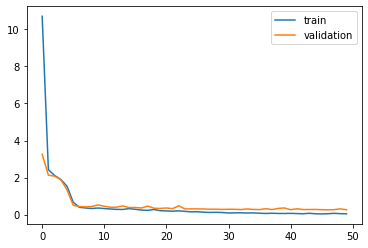

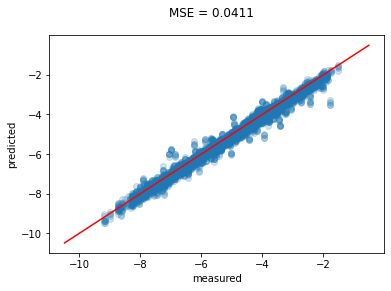

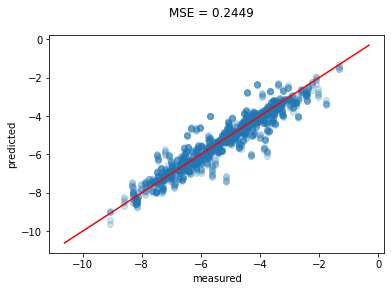

Initialised MolLoader with 1587 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.041603088378906 val loss 2.469212055206299
Epoch 1: train loss 2.3726000785827637 val loss 2.0353970527648926
Epoch 2: train loss 2.097363233566284 val loss 1.9225883483886719
Epoch 3: train loss 1.952493667602539 val loss 1.697246789932251
Epoch 4: train loss 1.2910239696502686 val loss 0.8904408812522888
Epoch 5: train loss 0.523353636264801 val loss 0.5510898232460022
Epoch 6: train loss 0.44319793581962585 val loss 0.45560166239738464
Epoch 7: train loss 0.3934779465198517 val loss 0.43387332558631897
Epoch 8: train loss 0.3580813705921173 val loss 0.4372783601284027
Epoch 9: train loss 0.36575037240982056 val loss 0.4423137605190277
Epoch 10: train loss 0.3388780951499939 val loss 0.

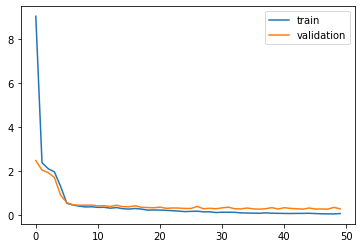

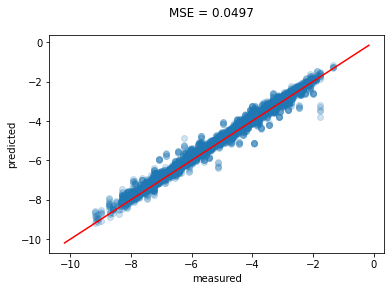

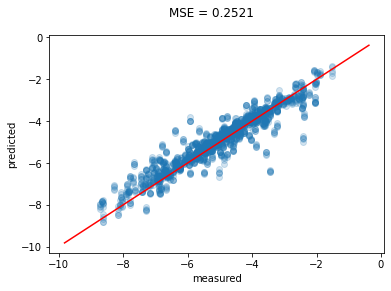

In [20]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

all_train_ys = []
all_train_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_train_ys.append(ys)
    all_train_y_hats.append(y_hats)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_ys.append(ys)
    all_y_hats.append(y_hats)

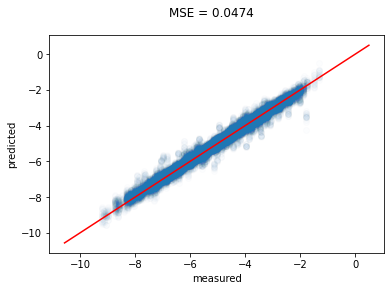

In [21]:
# 0.0474 50 epoch
plot_predictions(np.hstack(all_train_ys), np.hstack(all_train_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_cv_train.pdf")

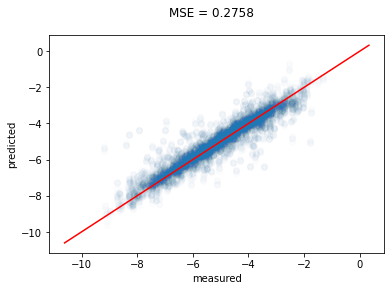

In [22]:
# 0.2758 50 epoch
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_cartesian_cv_test.pdf")

### Spherical

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.502177238464355 val loss 3.0760533809661865
Epoch 1: train loss 2.3846514225006104 val loss 2.1271567344665527
Epoch 2: train loss 1.9808366298675537 val loss 1.7859421968460083
Epoch 3: train loss 1.5927374362945557 val loss 1.1290299892425537
Epoch 4: train loss 0.6995949745178223 val loss 0.557758629322052
Epoch 5: train loss 0.4562518000602722 val loss 0.45538613200187683
Epoch 6: train loss 0.37533560395240784 val loss 0.40250957012176514
Epoch 7: train loss 0.35112464427948 val loss 0.475268691778183
Epoch 8: train loss 0.36676648259162903 val loss 0.3968456983566284
Epoch 9: train loss 0.33565542101860046 val loss 0.3872155249118805
Epoch 10: train loss 0.3338139057159424 val loss 

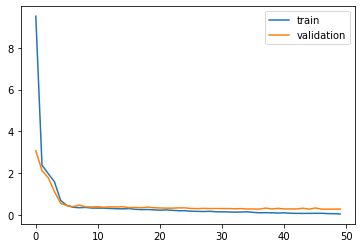

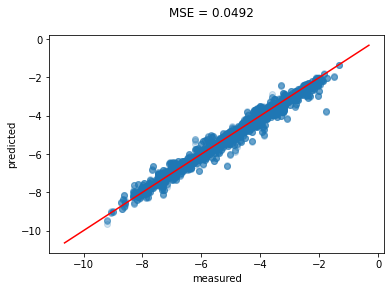

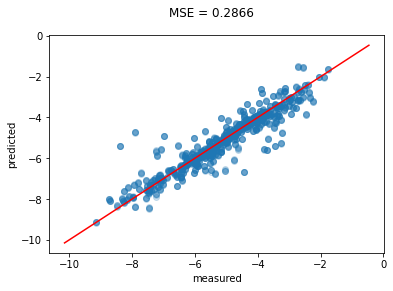

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 8.300583839416504 val loss 2.4712421894073486
Epoch 1: train loss 2.204289674758911 val loss 2.1116747856140137
Epoch 2: train loss 1.8652220964431763 val loss 1.8150805234909058
Epoch 3: train loss 1.3761979341506958 val loss 0.8657207489013672
Epoch 4: train loss 0.5404986143112183 val loss 0.400046169757843
Epoch 5: train loss 0.40220290422439575 val loss 0.34417176246643066
Epoch 6: train loss 0.3748241364955902 val loss 0.3636537790298462
Epoch 7: train loss 0.3900059461593628 val loss 0.40136364102363586
Epoch 8: train loss 0.35758736729621887 val loss 0.42326298356056213
Epoch 9: train loss 0.375186026096344 val loss 0.3346611559391022
Epoch 10: train loss 0.33773818612098694 val los

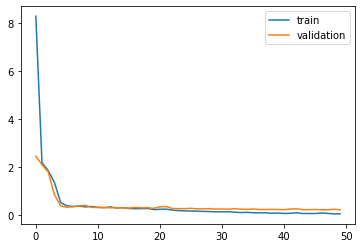

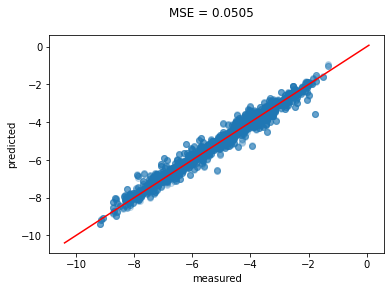

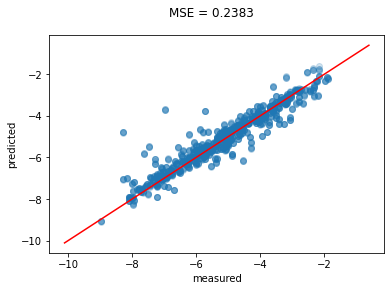

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 7.644886493682861 val loss 2.1543843746185303
Epoch 1: train loss 2.2196264266967773 val loss 2.318905830383301
Epoch 2: train loss 1.9521483182907104 val loss 1.73049795627594
Epoch 3: train loss 1.4900753498077393 val loss 0.959850013256073
Epoch 4: train loss 0.6888729333877563 val loss 0.5777531862258911
Epoch 5: train loss 0.41018611192703247 val loss 0.47994598746299744
Epoch 6: train loss 0.39960044622421265 val loss 0.49891167879104614
Epoch 7: train loss 0.3612569272518158 val loss 0.46541306376457214
Epoch 8: train loss 0.356208473443985 val loss 0.6141880750656128
Epoch 9: train loss 0.37962913513183594 val loss 0.44475477933883667
Epoch 10: train loss 0.3334520757198334 val loss

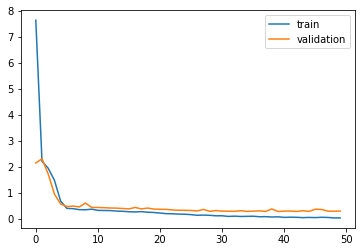

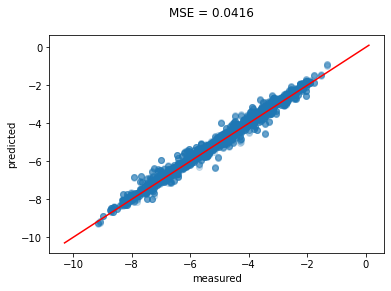

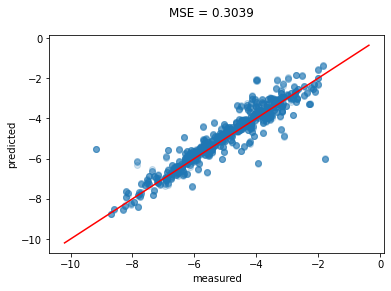

Initialised MolLoader with 1587 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 10.696922302246094 val loss 3.2161874771118164
Epoch 1: train loss 2.366929531097412 val loss 2.0244717597961426
Epoch 2: train loss 1.9570376873016357 val loss 1.797186017036438
Epoch 3: train loss 1.448425531387329 val loss 0.9981598258018494
Epoch 4: train loss 0.550682544708252 val loss 0.44888100028038025
Epoch 5: train loss 0.37435612082481384 val loss 0.40616294741630554
Epoch 6: train loss 0.3429403603076935 val loss 0.39548227190971375
Epoch 7: train loss 0.348318874835968 val loss 0.3867686092853546
Epoch 8: train loss 0.33056679368019104 val loss 0.3862816095352173
Epoch 9: train loss 0.3229845464229584 val loss 0.39734554290771484
Epoch 10: train loss 0.3107512593269348 val loss

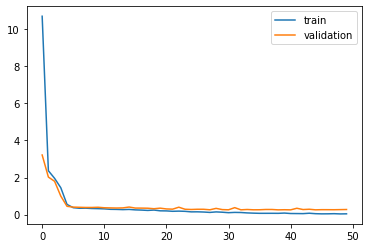

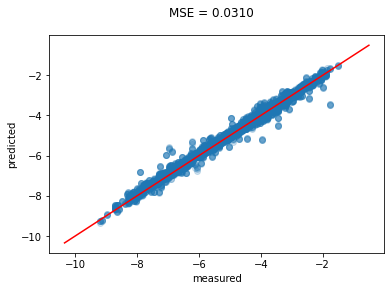

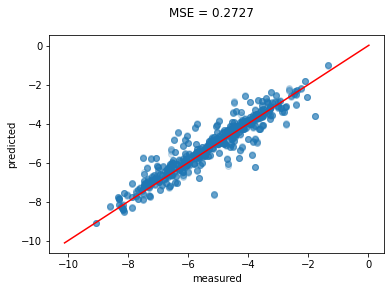

Initialised MolLoader with 1587 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 9.032503128051758 val loss 2.4419989585876465
Epoch 1: train loss 2.324307680130005 val loss 1.9562088251113892
Epoch 2: train loss 1.9334115982055664 val loss 1.6317023038864136
Epoch 3: train loss 1.288379430770874 val loss 0.5313864946365356
Epoch 4: train loss 0.469252347946167 val loss 0.42578062415122986
Epoch 5: train loss 0.400208979845047 val loss 0.3932375907897949
Epoch 6: train loss 0.38806435465812683 val loss 0.423854261636734
Epoch 7: train loss 0.3503458797931671 val loss 0.36831504106521606
Epoch 8: train loss 0.33549922704696655 val loss 0.37977051734924316
Epoch 9: train loss 0.3737372159957886 val loss 0.5098492503166199
Epoch 10: train loss 0.3375024199485779 val loss 0

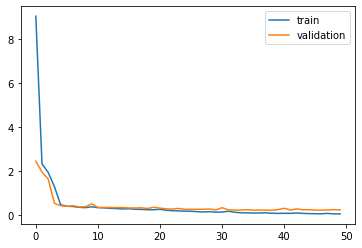

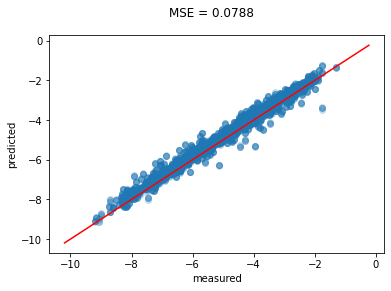

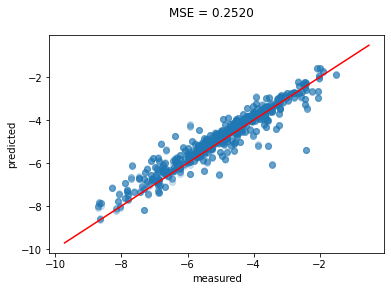

In [23]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

all_train_ys = []
all_train_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='spherical')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='spherical')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_train
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_train_ys.append(ys)
    all_train_y_hats.append(y_hats)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    all_ys.append(ys)
    all_y_hats.append(y_hats)

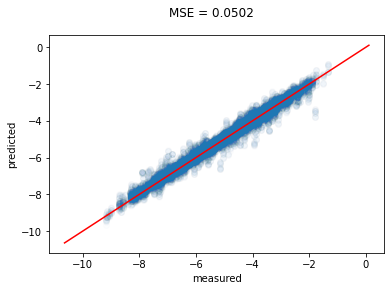

In [24]:
# 0.0502 50 epoch
plot_predictions(np.hstack(all_train_ys), np.hstack(all_train_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_cv_train.pdf")

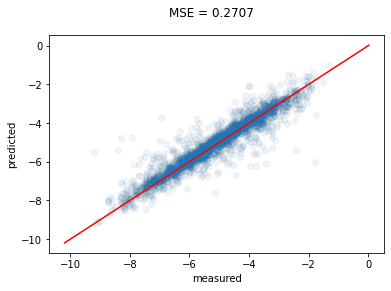

In [25]:
# 0.2707 50 epoch
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)
plt.savefig(fig_folder + data_name + "_spherical_cv_test.pdf")

## Parameter Grid Search

In [26]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

(1784, 13) (199, 13)


In [27]:
param_grid = ParameterGrid({
    "sigma": [0.01, 0.1, 0.5, 1.],
    "L": [10, 12.8, 15],
    "weight_decay": [0., 0.001, 0.01]
})

In [28]:
len(list(param_grid))

36

0. L = 10, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1784 compounds.
    sigma=0.01, L=10, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.01, L=10, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Finished in 938.1339s.                               


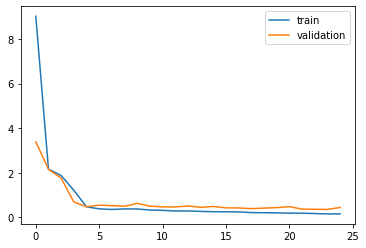

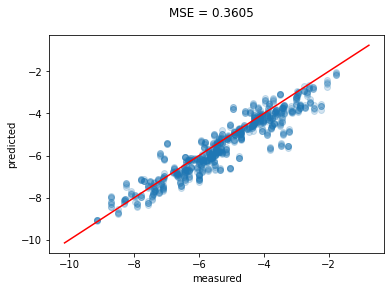

1. L = 10, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1784 compounds.
    sigma=0.01, L=10, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.01, L=10, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Finished in 935.5935s.                               


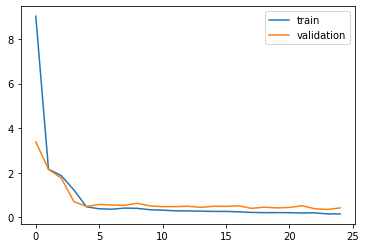

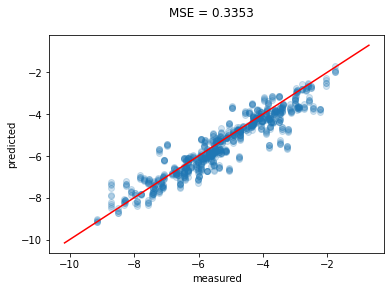

2. L = 10, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1784 compounds.
    sigma=0.01, L=10, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.01, L=10, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda
Finished in 947.1112s.                               


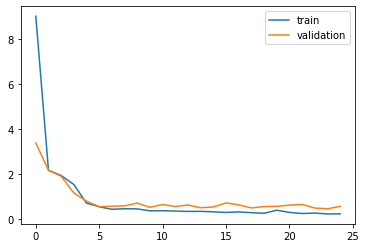

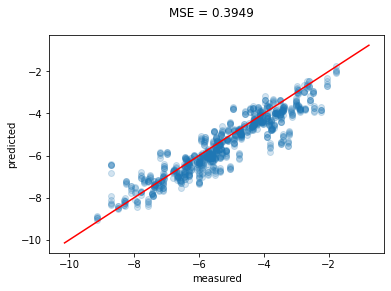

3. L = 10, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1784 compounds.
    sigma=0.1, L=10, N=32, nchannel=79, mode=cartesian, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 compounds.
    sigma=0.1, L=10, N=32, nchannel=79, mode=cartesian, shuffle=False, rotate=False, device=cuda


KeyboardInterrupt: 

In [29]:
epochs = 25
N = 32

device = get_default_device()

results = []

for i, params in enumerate(param_grid):
    L = params["L"]
    sigma = params["sigma"]
    weight_decay = params["weight_decay"]
    print(f"{i}. L = {L}, sigma = {sigma}, weight_decay = {weight_decay}")

    seed_everything()
    
    net = VoxelNet(nchannel)
    net = net.to(device)

    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=64, nchannel=nchannel,
                   shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                       L=L, N=N, batch_size=128, nchannel=nchannel,
                       shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')

    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, verbose=False)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    plt.show()
    
    results.append(np.mean((ys - y_hats)**2))

In [ ]:
for param, mse in zip(param_grid, results):
    print(param, mse)

In [ ]:
amin = np.argmin(results)
param_grid[amin], results[amin]